In [1]:
import matplotlib.pyplot as plt
import sys
from sklearn.cluster import AgglomerativeClustering

from src.contact_matrices import *
from src.est import *

## Content

In this notebook we share the code used to obtain the main results of our paper. 


### Figure 2

Aggregated household contact matrices. As explained in the `example` notebook, the contact matrices are loaded in a dictionary of classes and then are aggregated to obtain the matrices referred to each deployment.

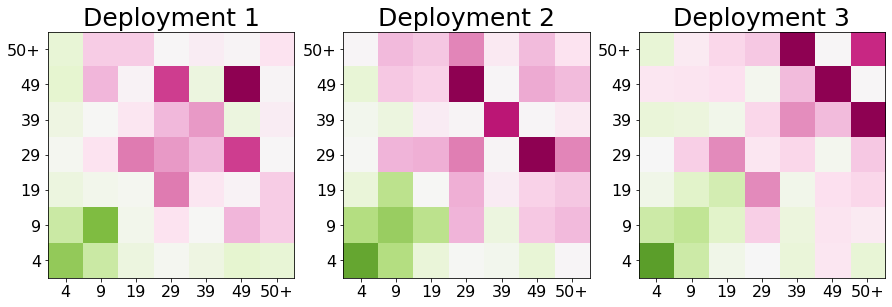

In [2]:
# Load the data
CM = LoadMatrices()

fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for d in range(3):
    # Aggregate over all household in the same deployment
    C = np.mean([CM[h,d].C_counts for h in range(60)], axis = 0)
    T = np.mean([CM[h,d].T for h in range(60)], axis = 0)

    R = C/T
    R = R/np.mean(R)
    ax[d].imshow(np.log10(R), cmap = 'PiYG', vmin = -1., vmax = 1., origin = 'lower')
    ax[d].set_xticks(np.arange(7))
    ax[d].set_xticklabels(['4', '9', '19', '29','39', '49', '50+'], fontsize = 16)
    ax[d].set_yticks(np.arange(7))
    ax[d].set_yticklabels(['4', '9', '19', '29','39', '49', '50+'], fontsize = 16)
    ax[d].set_title(f'Deployment {d+1}', fontsize = 25)

plt.show();

### Figure 3

In [5]:
H_v, dCos, EstC_list, embedding = [], [], [], []
dCosT, dCosP, Clist, Tlist = [], [], [], []

# number of "villages"
n = 500

# number of households in each "village"
n_households = 8

for i in range(n):
    print("[%-25s] %d%%" % ('='*(int((i+1)  /n*25)-1) + '>', (i+1)/(n)*100), end = '\r')

    # create the village
    selected_hd = formCompleteHousehold(CM, n_households)

    # obtain the rank 1 approximation
    EstC = EstimateC(CM, selected_hd, dist = 'CanberraDistance')
    EstCP = EstimateC(CM, selected_hd, dist = 'CanberraDistance', name = 'P')
    # EstC_list.append(EstC)

    H_v.append(selected_hd)
    # dCanberra.append(EstC.dCanberra)
    dCos.append(EstC.dCos)
    dCosP.append(EstCP.dCos)

    T = np.mean([CM[x].T.values for x in selected_hd], axis = 0)
    C = np.mean([CM[x].C_counts.values for x in selected_hd], axis = 0)
    Clist.append(C)
    Tlist.append(T)
    dCosT.append(CosineSimilarityMat(T, C))
    embedding.append(EstC.u.T[0])

embedding = np.array(embedding)

# perform clustering
k = 4
cluster = AgglomerativeClustering(n_clusters= k, affinity='euclidean', linkage='ward')
ℓ = cluster.fit_predict(embedding)

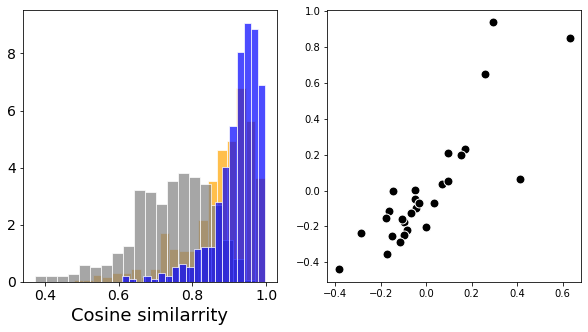

In [6]:
fs = 14
ffs = 18
    
fig, ax = plt.subplots(1,2, figsize = (10,5))
    
ax[0].hist(np.array(dCos), bins = 20, color = "orange", edgecolor = "white", alpha = 0.7, density = True)
ax[0].hist(np.array(dCosT), bins = 20, color = "grey", edgecolor = "white", alpha = 0.7, density = True)
ax[0].hist(np.array(dCosP), bins = 20, color = "blue", edgecolor = "white", alpha = 0.7, density = True)
ax[0].tick_params(axis='both', labelsize = fs)
ax[0].set_xlabel("Cosine similarrity", fontsize = ffs)

n_age_p, _ = CM[0,0].T.shape
Q = np.zeros((len(H_v), n_age_p))

for i in range(len(H_v)):
    C = Clist[i]
    T = Tlist[i]
    Π = np.diag((np.sum(T, axis = 0))**(-1))
        
    v = np.sum(Π@C, axis = 0)
    v = v/np.mean(v)
    Q[i] = v

Qm = np.concatenate([np.mean(Q[ℓ == p], axis = 0) - np.mean(Q, axis = 0) for p in range(k)])
Vm = np.concatenate([np.mean(embedding[ℓ == p], axis = 0) - np.mean(embedding, axis = 0) for p in range(k)])
ax[1].scatter(Qm, Vm, color = 'k', edgecolor = 'white', s = 80)

plt.show();
